In [ ]:
!pip install kymatio
!pip install ase



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 40.4 MB/s eta 0:00:00


In [ ]:
import zipfile
import os

# Assuming the uploaded file is named 'yourfile.zip'
zip_file_name = '/content/defi-modia-2024.zip'

# Create a directory to extract the contents
extracted_dir = 'extracted_data'
os.makedirs(extracted_dir, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

print(f"Files extracted to: {extracted_dir}")

Files extracted to: extracted_data


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
test_scattering_coefs = np.load("/content/scattering_coef_test_tartbit.npy")

In [ ]:
import torch

In [ ]:
order_0_train = torch.load("/content/order_0_tartibcat.pt")
order_1_2_train = torch.load("/content/order_1_and_2_tartibcat.pt")

In [ ]:
csv_file_path = '/content/extracted_data/data/energies/train.csv'
energies_df = pd.read_csv(csv_file_path)
target_energies = energies_df['energy'].values

In [ ]:
n_molecules_train = 4628
n_molecules_test = 1156

In [ ]:
order_0_train.shape

(4628, 4, 3)

In [ ]:
order_0_train = order_0_train.reshape((n_molecules_train, -1))
orders_1_and_2_train = order_1_2_train.reshape((n_molecules_train, -1))


In [ ]:
scattering_coef_train = np.concatenate([order_0_train, orders_1_and_2_train], axis=1)


In [ ]:
n_folds = 4

P = np.random.permutation(n_molecules_train).reshape((n_folds, -1))

cross_val_folds = []

for i_fold in range(n_folds):
    fold = (np.concatenate(P[np.arange(n_folds) != i_fold], axis=0),
            P[i_fold])
    cross_val_folds.append(fold)

In [ ]:
from sklearn import (linear_model, model_selection, preprocessing,
                     pipeline)
from scipy.spatial.distance import pdist

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.50407e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.39157e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.47378e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.70899e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge regression, alpha: 0.09999999999999999, MAE: 0.11692283353526911, RMSE: 0.17628184442904152
Ridge regression, alpha: 0.01, MAE: 0.0823445355853914, RMSE: 0.17257080237967282
Ridge regression, alpha: 0.001, MAE: 0.06442281088879698, RMSE: 0.21221869156541384
Ridge regression, alpha: 9.999999999999999e-05, MAE: 0.05101743448605538, RMSE: 0.18146810185548362
Ridge regression, alpha: 9.999999999999999e-06, MAE: 0.051469685418370346, RMSE: 0.41169140073107363
Ridge regression, alpha: 1e-06, MAE: 0.05596596362321542, RMSE: 0.6955203540649618
Ridge regression, alpha: 1e-07, MAE: 0.055105743389966856, RMSE: 0.7662073198087772
Ridge regression, alpha: 1e-08, MAE: 0.052278321449969516, RMSE: 0.6827610085864372
Ridge regression, alpha: 9.999999999999999e-10, MAE: 0.05257591226737033, RMSE: 0.5572463450711066


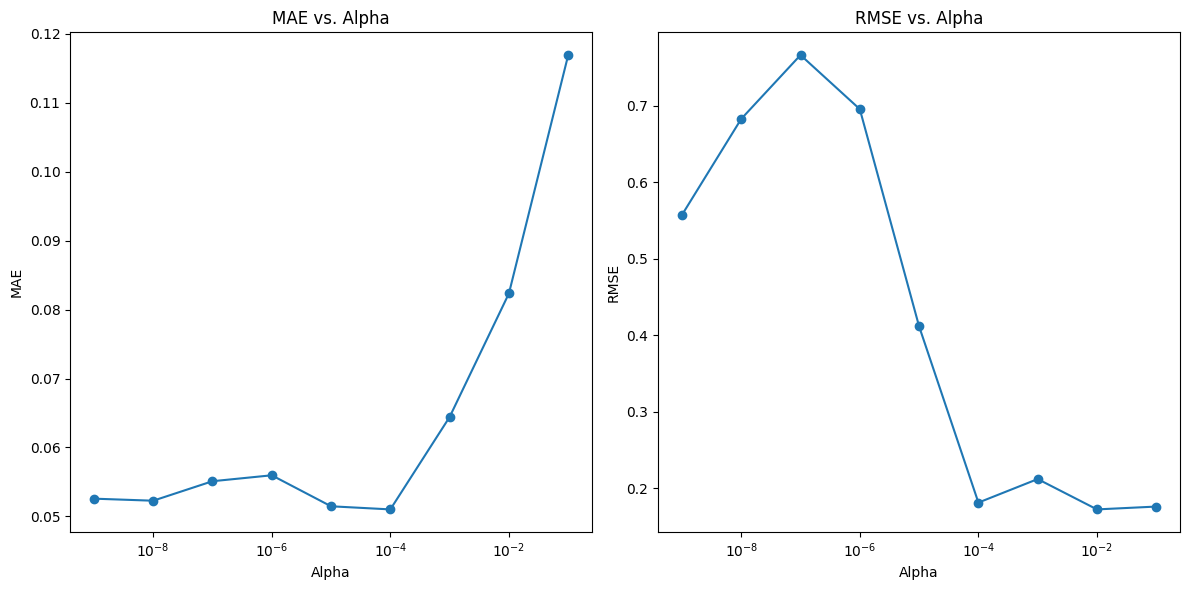

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing, linear_model, pipeline, model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Number of folds for cross-validation
n_folds = 4
n_molecules_train = len(scattering_coef_train)

# Create cross-validation folds
P = np.random.permutation(n_molecules_train).reshape((n_folds, -1))
cross_val_folds = []

for i_fold in range(n_folds):
    fold = (np.concatenate(P[np.arange(n_folds) != i_fold], axis=0),
            P[i_fold])
    cross_val_folds.append(fold)

# List of alpha values to evaluate
alphas = 10.0 ** (-np.arange(1, 10))
mae_scores = []
rmse_scores = []

for i, alpha in enumerate(alphas):
    scaler = preprocessing.StandardScaler()
    ridge = linear_model.Ridge(alpha=alpha)

    regressor = pipeline.make_pipeline(scaler, ridge)

    target_prediction = model_selection.cross_val_predict(regressor,
            X=scattering_coef_train, y=target_energies, cv=cross_val_folds)

    MAE = np.mean(np.abs(target_prediction - target_energies))
    RMSE = np.sqrt(np.mean((target_prediction - target_energies) ** 2))

    mae_scores.append(MAE)
    rmse_scores.append(RMSE)

    print(f'Ridge regression, alpha: {alpha}, MAE: {MAE}, RMSE: {RMSE}')

# Plotting the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(alphas, mae_scores, marker='o')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('MAE')
plt.title('MAE vs. Alpha')

plt.subplot(1, 2, 2)
plt.plot(alphas, rmse_scores, marker='o')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.title('RMSE vs. Alpha')

plt.tight_layout()
plt.show()


In [ ]:
n_folds = 4

P = np.random.permutation(n_molecules_train).reshape((n_folds, -1))

cross_val_folds = []

for i_fold in range(n_folds):
    fold = (np.concatenate(P[np.arange(n_folds) != i_fold], axis=0),
            P[i_fold])
    cross_val_folds.append(fold)

alphas = 10.0 ** (-np.arange(1, 10))
for i, alpha in enumerate(alphas):
    scaler = preprocessing.StandardScaler()
    ridge = linear_model.Ridge(alpha=alpha)

    regressor = pipeline.make_pipeline(scaler, ridge)

    target_prediction = model_selection.cross_val_predict(regressor,
            X=scattering_coef_train, y=target_energies, cv=cross_val_folds)

    MAE = np.mean(np.abs(target_prediction - target_energies))
    RMSE = np.sqrt(np.mean((target_prediction - target_energies) ** 2))

    print('Ridge regression, alpha: {}, MAE: {}, RMSE: {}'.format(
        alpha, MAE, RMSE))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.56613e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.72868e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.56445e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.30568e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge regression, alpha: 0.09999999999999999, MAE: 0.11641599942828636, RMSE: 0.1722967410700668
Ridge regression, alpha: 0.01, MAE: 0.08186283821060766, RMSE: 0.2105401774631127
Ridge regression, alpha: 0.001, MAE: 0.06533304929556484, RMSE: 0.31063326257517565
Ridge regression, alpha: 9.999999999999999e-05, MAE: 0.05392192948778548, RMSE: 0.2875938426926654
Ridge regression, alpha: 9.999999999999999e-06, MAE: 0.053517599891931, RMSE: 0.5404036934385799
Ridge regression, alpha: 1e-06, MAE: 0.0630030303012105, RMSE: 0.9736949294184563
Ridge regression, alpha: 1e-07, MAE: 0.07434020962201783, RMSE: 1.4177277351696518
Ridge regression, alpha: 1e-08, MAE: 0.07112123794909633, RMSE: 1.2946728277876824
Ridge regression, alpha: 9.999999999999999e-10, MAE: 0.056177994875487955, RMSE: 0.7188218954806633


In [ ]:
test_ds = "/content/extracted_data/atoms/test"


# Get list of test filenames (excluding file extension)
test_filenames = [os.path.splitext(f)[0] for f in sorted(os.listdir(test_ds)) if f.endswith('.xyz')]


test_filenames = [int(test_filenames[i][3:]) for i in range(len(test_filenames))]

In [ ]:
import numpy as np
from sklearn import preprocessing, linear_model, pipeline, model_selection
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
import numpy as np
from sklearn import preprocessing, linear_model, pipeline, model_selection
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Number of folds for cross-validation
n_folds = 4
n_molecules_train = len(scattering_coef_train)  # Ensure you have the correct length

# Create cross-validation folds
P = np.random.permutation(n_molecules_train).reshape((n_folds, -1))
cross_val_folds = []

for i_fold in range(n_folds):
    fold = (np.concatenate(P[np.arange(n_folds) != i_fold], axis=0),
            P[i_fold])
    cross_val_folds.append(fold)

# Set the desired hyperparameters
best_alpha = 1e-10
n_estimators = 150
learning_rate = 0.011

# Define the base regressor with the specified alpha
base_ridge = linear_model.Ridge(alpha=best_alpha)

# Create the AdaBoost regressor with the specified parameters
boosting_regressor = AdaBoostRegressor(base_estimator=base_ridge, n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)

# Create the pipeline
scaler = preprocessing.StandardScaler()

regressor = pipeline.Pipeline([
    ('scaler', scaler),
    ('boosting', boosting_regressor)
])

# Perform cross-validation
target_prediction = model_selection.cross_val_predict(regressor, X=scattering_coef_train, y=target_energies, cv=cross_val_folds)

# Calculate MAE and RMSE
MAE = mean_absolute_error(target_energies, target_prediction)
MSE = mean_squared_error(target_energies, target_prediction)

print(f'Boosting Ridge regression with specified parameters, MAE: {MAE}, RMSE: {MSE}')

# Fit the model on the entire training data
regressor.fit(scattering_coef_train, target_energies)

# Predict on the test data
test_predictions = regressor.predict(test_scattering_coefs)


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Boosting Ridge regression with specified parameters, MAE: 0.03728494074268223, RMSE: 0.020927071843008755


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [ ]:
import numpy as np
from sklearn import preprocessing, linear_model, pipeline, model_selection
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error

# Define a custom scorer for GridSearchCV to output MAE
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Number of folds for cross-validation
n_folds = 4
n_molecules_train = len(scattering_coef_train)  # Ensure you have the correct length

# Create cross-validation folds
P = np.random.permutation(n_molecules_train).reshape((n_folds, -1))
cross_val_folds = []

for i_fold in range(n_folds):
    fold = (np.concatenate(P[np.arange(n_folds) != i_fold], axis=0),
            P[i_fold])
    cross_val_folds.append(fold)

# Set the desired hyperparameters grid
param_grid = {
    'boosting__n_estimators': [ 150],
    'boosting__learning_rate': [0.0097, 0.01, 0.015, 0.02],
    'boosting__base_estimator__alpha': [1e-10]
}

# Define the base regressor with the specified alpha
base_ridge = linear_model.Ridge()

# Create the AdaBoost regressor
boosting_regressor = AdaBoostRegressor(base_estimator=base_ridge, random_state=42)

# Create the pipeline
scaler = preprocessing.StandardScaler()
regressor = pipeline.Pipeline([
    ('scaler', scaler),
    ('boosting', boosting_regressor)
])

# Perform grid search with cross-validation
grid_search = model_selection.GridSearchCV(
    regressor,
    param_grid,
    scoring={'MAE': mae_scorer, 'RMSE': rmse_scorer},
    refit='MAE',  # Refit using the model that gives the best MAE score
    cv=cross_val_folds,
    verbose=2,
    n_jobs=-1
)

# Fit the grid search
grid_search.fit(scattering_coef_train, target_energies)

# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best MAE score: ", -grid_search.best_score_)

# Print scores for all parameter combinations
for mean_score, params in zip(grid_search.cv_results_['mean_test_MAE'], grid_search.cv_results_['params']):
    rmse_score = [score for mean, score, param in zip(grid_search.cv_results_['mean_test_MAE'], grid_search.cv_results_['mean_test_RMSE'], grid_search.cv_results_['params']) if param == params]
    print(f"Params: {params} - MAE: {-mean_score} - RMSE: {np.sqrt(-rmse_score[0])}")

# Use the best model to predict on the test data
best_model = grid_search.best_estimator_
test_predictions = best_model.predict(test_scattering_coefs)

Fitting 4 folds for each of 4 candidates, totalling 16 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Best parameters found:  {'boosting__base_estimator__alpha': 1e-10, 'boosting__learning_rate': 0.01, 'boosting__n_estimators': 150}
Best MAE score:  1.8335295971569512
Params: {'boosting__base_estimator__alpha': 1e-10, 'boosting__learning_rate': 0.0097, 'boosting__n_estimators': 150} - MAE: 1.902008606715679 - RMSE: 89.53227679945635
Params: {'boosting__base_estimator__alpha': 1e-10, 'boosting__learning_rate': 0.01, 'boosting__n_estimators': 150} - MAE: 1.8335295971569512 - RMSE: 86.26883041186508
Params: {'boosting__base_estimator__alpha': 1e-10, 'boosting__learning_rate': 0.015, 'boosting__n_estimators': 150} - MAE: 2.3302349114512664 - RMSE: 110.21731885176946
Params: {'boosting__base_estimator__alpha': 1e-10, 'boosting__learning_rate': 0.02, 'boosting__n_estimators': 150} - MAE: 2.9128840364153015 - RMSE: 138.23084776779325


In [ ]:
import numpy as np
from sklearn import preprocessing, linear_model, pipeline, model_selection
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Number of folds for cross-validation
n_folds = 4
n_molecules_train = len(scattering_coef_train)  # Ensure you have the correct length

# Create cross-validation folds
P = np.random.permutation(n_molecules_train).reshape((n_folds, -1))
cross_val_folds = []

for i_fold in range(n_folds):
    fold = (np.concatenate(P[np.arange(n_folds) != i_fold], axis=0),
            P[i_fold])
    cross_val_folds.append(fold)

# Set the desired hyperparameters
best_alpha = 1e-10
n_estimators = 150
learning_rate = 0.01

# Define the base regressor with the specified alpha
base_ridge = linear_model.Ridge(alpha=best_alpha)

# Create the AdaBoost regressor with the specified parameters
boosting_regressor = AdaBoostRegressor(base_estimator=base_ridge, n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)

# Create the pipeline
scaler = preprocessing.StandardScaler()

regressor = pipeline.Pipeline([
    ('scaler', scaler),
    ('boosting', boosting_regressor)
])

# Perform cross-validation
target_prediction = model_selection.cross_val_predict(regressor, X=scattering_coef_train, y=target_energies, cv=cross_val_folds)

# Calculate MAE and RMSE
MAE = mean_absolute_error(target_energies, target_prediction)
MSE = mean_squared_error(target_energies, target_prediction)

print(f'Boosting Ridge regression with specified parameters, MAE: {MAE}, RMSE: {MSE}')

# Fit the model on the entire training data
regressor.fit(scattering_coef_train, target_energies)

# Predict on the test data
test_predictions = regressor.predict(test_scattering_coefs)


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Boosting Ridge regression with specified parameters, MAE: 0.039924260107804525, RMSE: 0.06215902444767119


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [ ]:
submission_df = pd.DataFrame({'id': test_filenames, 'energy': test_predictions})

# Save to CSV
submission_df.to_csv('minus1.csv', index=False)
